In [27]:
import numpy as np
import cv2
from PIL import Image
import time
import matplotlib.pyplot as plt

from mss.linux import MSS as mss
# uncomment the following line if you are using windows
# from mss.windows import MSS as mss

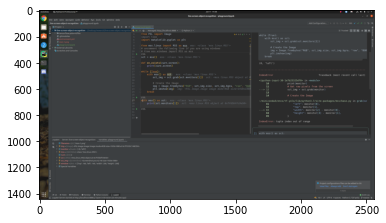

In [31]:
sct = mss()

def on_exists(curr_screen):
    print(curr_screen)

while (True):
    with mss() as sct:
        sct_img = sct.grab(sct.monitors[1])

        # Create the Image
        img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")
        plt.imshow(img)
    break

In [21]:
with mss() as sct:
    print(sct.monitors[1])

{'left': 1920, 'top': 0, 'width': 2560, 'height': 1440}
